In [1]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
import os
import glob
path = "D:/notebook/Deep Learning Course/files/"

In [3]:
files = os.listdir(path)
print(len(files))
print(files)

132
['00735.atr', '00735.hea', '00735.qrs', '03665.atr', '03665.hea', '03665.qrs', '04015.atr', '04015.dat', '04015.hea', '04015.hea-', '04015.qrs', '04043.atr', '04043.dat', '04043.hea', '04043.hea-', '04043.qrs', '04048.atr', '04048.dat', '04048.hea', '04048.hea-', '04048.qrs', '04126.atr', '04126.dat', '04126.hea', '04126.hea-', '04126.qrs', '04746.atr', '04746.dat', '04746.hea', '04746.hea-', '04746.qrs', '04908.atr', '04908.dat', '04908.hea', '04908.hea-', '04908.qrs', '04936.atr', '04936.dat', '04936.hea', '04936.hea-', '04936.qrs', '04936.xws', '05091.atr', '05091.dat', '05091.hea', '05091.hea-', '05091.qrs', '05091.qrsc', '05121.atr', '05121.atr-', '05121.dat', '05121.hea', '05121.hea-', '05121.qrs', '05261.atr', '05261.dat', '05261.hea', '05261.hea-', '05261.qrs', '06426.atr', '06426.dat', '06426.hea', '06426.hea-', '06426.qrs', '06453.atr', '06453.dat', '06453.hea', '06453.hea-', '06453.qrs', '06995.atr', '06995.dat', '06995.hea', '06995.hea-', '06995.qrs', '07162.atr', '0716

In [4]:
files = [file.split('.')[0] for file in files]
for x in ['old', 'index', 'RECORDS', 'ANNOTATORS', 'SHA256SUMS', 'notes']:
    if x in files:
        files.remove(x)
files = list(set(files))

In [5]:
record_name = os.path.join(path, files[10])
record_name

'D:/notebook/Deep Learning Course/files/08219'

In [6]:
record = wfdb.rdheader(record_name)
print(f"Record: {record.record_name}")
print(f"Sampling frequency: {record.fs} Hz")
print(f"Signal length: {record.sig_len} samples")
print(f"Duration: {record.sig_len/record.fs:.2f} seconds")

Record: 08219
Sampling frequency: 250 Hz
Signal length: 9205760 samples
Duration: 36823.04 seconds


In [7]:
annotations = wfdb.rdann(record_name, 'atr')
print(f"\nAnnotation file (.atr) loaded:")
print(f"Number of annotations: {len(annotations.sample)}")
print(f"Annotation symbols: {set(annotations.symbol)}")
print(f"annotation symbols : {annotations.symbol}")
print(f"annotation sample : {annotations.sample}")


Annotation file (.atr) loaded:
Number of annotations: 79
Annotation symbols: {'+'}
annotation symbols : ['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+']
annotation sample : [    172 3077924 3126813 3144896 3236450 3272405 3373026 3385696 3491433
 3534149 3593003 3603735 3664616 3679789 3813870 3824127 3841689 3854499
 3873943 4433500 4537195 4544500 4569750 4581494 4668721 4676269 4708991
 4717972 4736918 4742277 4778243 4788054 4806612 4818981 4863752 4873479
 4900296 4911280 4928796 4941994 4966821 4980705 5012329 5020409 5067426
 5074252 5083417 5091007 5105317 5116801 5158000 5170948 5189837 5203078
 5308514 5319425 5370405 5404332 5469500 

In [8]:
channels = []
rhythms = []
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    qrs = wfdb.rdann(record_name, 'qrs')
    rhythms.append(np.unique(qrs.symbol))
    channels.append(np.unique(ann.chan))

In [9]:
# qrs_annotations = wfdb.rdann(record_name, 'qrs')
# qrs_annotations.sample
# qrs_annotations.symbol
# np.unique(qrs_annotations.symbol)
print(rhythms)
print(channels)


[array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1')]
[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0])]


In [12]:
print(rhythms)

[array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1')]


In [23]:
shortest_interval =[]
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    if ann.sample.shape[0] > 1:
        shortest_interval.append(np.min(ann.sample[1:]-ann.sample[:-1]))

In [27]:
def create_training_data(path:str, file_name:str, window:int, shift:int):
    record_name = os.path.join(path, file_name)
    signal = wfdb.rdrecord(record_name)
    ann = wfdb.rdann(record_name, 'atr')
    boundary_count = 0
    current_boundary = ann.sample[boundary_count]
    start = 0
    data = []
    label = []
    while start+window < signal.p_signal.shape[0]:
        data.append(signal.p_signal[start:start+window,:])
        if not start < current_boundary < start + window:
            label.append(0) if boundary_count % 2 == 0 else label.append(1)
        else:
            percent = (ann.sample[boundary_count] - start)/window * 100
            if percent > 50:
                label.append(0) if boundary_count % 2 == 0 else label.append(1)
            else:
                label.append(1) if boundary_count % 2 == 0 else label.append(0)
        start += shift
        if start > ann.sample[boundary_count] and boundary_count < len(ann.sample)-1:
            boundary_count += 1
        current_boundary = ann.sample[boundary_count]
            
    return np.array(data), np.array(label)


In [28]:
index = 20
record_name = os.path.join(path, files[index])
ann = wfdb.rdann(record_name, 'atr')
ann.sample, ann.symbol

(array([     54, 1783080, 7333067, 7334783, 7335468]),
 ['+', '+', '+', '+', '+'])

In [29]:
x, y = create_training_data(path, files[index], 2500, 1250)
print(x.shape)
df = pd.DataFrame(y, columns=['label'])
print(df.label.value_counts())

(7363, 2500, 2)
label
0    5935
1    1428
Name: count, dtype: int64


In [30]:
ch1_cols = [f"feature_{id}" for id in range(x.shape[1])]
ch2_cols = [f"feature_{id}" for id in range(x.shape[1])]
ch1 = pd.DataFrame(x[:, :, 0], columns=ch1_cols)
ch2 = pd.DataFrame(x[:, :, 1], columns=ch2_cols)

ch1['label']=  y
ch2['label'] = y

# data = pd.DataFrame(x, y, columns=columns)
# data['label'] = y

# with pd.ExcelWriter("ecg_data.xlsx") as writer:
#     ch1.to_excel(writer, sheet_name="Channel_1", index=False)
#     ch2.to_excel(writer, sheet_name="Channel_2", index=False)

In [31]:
ch1

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_2491,feature_2492,feature_2493,feature_2494,feature_2495,feature_2496,feature_2497,feature_2498,feature_2499,label
0,-0.010,0.000,-0.015,-0.005,0.000,0.000,-0.010,0.015,0.000,0.000,...,-0.005,-0.020,-0.010,-0.010,-0.015,-0.010,-0.025,-0.010,-0.010,1
1,-0.035,-0.035,-0.025,-0.030,-0.005,-0.010,-0.015,-0.025,-0.020,-0.025,...,0.055,0.035,0.050,0.045,0.060,0.065,0.065,0.055,0.045,1
2,0.000,-0.030,-0.020,-0.020,-0.020,-0.025,-0.025,-0.030,-0.025,-0.030,...,-0.125,-0.125,-0.130,-0.110,-0.130,-0.130,-0.130,-0.120,-0.135,1
3,0.055,0.050,0.050,0.035,0.030,0.050,0.050,0.035,0.035,0.020,...,-0.180,-0.200,-0.205,-0.215,-0.205,-0.180,-0.190,-0.195,-0.205,1
4,-0.110,-0.125,-0.125,-0.130,-0.115,-0.120,-0.130,-0.130,-0.130,-0.140,...,0.040,0.105,0.175,0.225,0.200,0.110,-0.030,-0.200,-0.255,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,-0.025,-0.015,0.000,0.000,0.015,0.025,0.040,0.040,0.045,0.030,...,-0.045,-0.035,-0.030,-0.030,-0.035,-0.030,-0.045,-0.030,-0.025,0
7359,-0.035,-0.030,-0.010,-0.025,-0.015,-0.005,-0.005,-0.010,-0.015,-0.025,...,0.010,0.025,0.020,0.030,0.030,0.020,0.025,0.000,0.015,0
7360,-0.020,-0.040,-0.030,-0.035,-0.040,-0.030,-0.020,-0.015,-0.015,-0.020,...,0.005,-0.005,-0.025,-0.015,-0.020,-0.020,-0.020,-0.045,-0.030,0
7361,0.025,0.020,0.020,0.025,0.015,0.000,0.005,0.010,0.005,0.010,...,0.020,0.030,0.020,0.030,0.015,0.010,0.015,0.010,0.015,0


In [ ]:
ch1['label'].value_counts()
normal = ch1[ch1['label'] == 0].iloc[:-1].values
af = ch1[ch1['label'] == 1].values

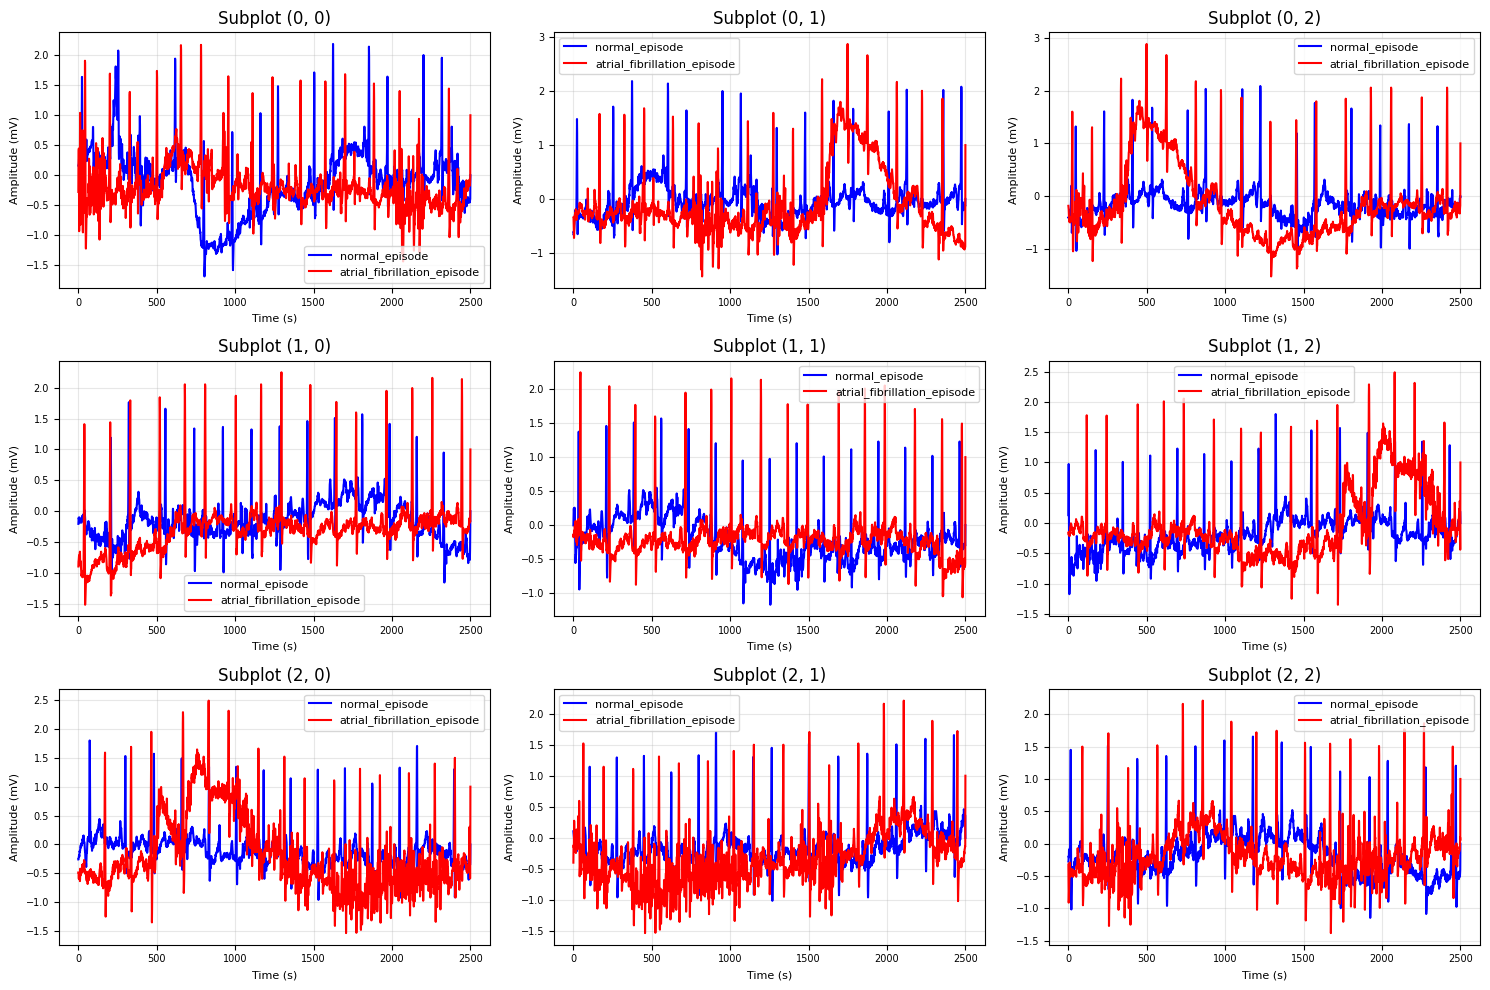

In [66]:

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(normal[fig_index], 'b-', label='normal_episode')
        axes[i, j].plot(af[fig_index], 'r-', label='atrial_fibrillation_episode')
        axes[i, j].set_title(f'Subplot ({i}, {j})')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

<h2>Loading .Mat file </h2>

In [32]:
from scipy.io import loadmat

In [42]:
mat_file_path = 'D:/notebook/Deep Learning Course/Atrial-Fibrillation-Detection/data/A_0001_2.mat'
mat_data = loadmat(mat_file_path)

In [ ]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECG_data', 'Radar_data'])

In [44]:
mat_data['Radar_data'].shape, mat_data['ECG_data'].shape

((1000, 3, 3), (1000, 1))

<h2>Frequency Domain Visualization </h2>

<h4> Single Channel ECG FFT </h4>

In [81]:
sample_ecg_data = x[0]
print(sample_ecg_data.shape)
print(sample_ecg_data)

ecg1 = sample_ecg_data[:, 0]
ecg2 = sample_ecg_data[:, 1]
print(ecg1.shape, ecg2.shape)

(2500, 2)
[[-0.01  -0.16 ]
 [ 0.    -0.16 ]
 [-0.015 -0.14 ]
 ...
 [-0.025 -0.365]
 [-0.01  -0.385]
 [-0.01  -0.385]]
(2500,) (2500,)


In [80]:
freq = np.fft.fftfreq(ecg1.shape[-1])
freq_data = np.fft.fft(ecg1)
print(f"Frequency : {freq}, \n")
print(f"Real part :{freq_data.real}")
print(f"imaginary part: {freq_data.imag}")

Frequency : [ 0.      0.0004  0.0008 ... -0.0012 -0.0008 -0.0004], 

Real part :[-51.965      -15.35126786   7.57582501 ...   7.27065658   7.57582501
 -15.35126786]
imaginary part: [  0.          -3.48109832 -10.35921092 ...  10.95876901  10.35921092
   3.48109832]


In [ ]:
fft_mag = np.abs(freq_data)
fft_mag.shape, fft_mag

((2500,),
 array([51.965     , 15.74101237, 12.83379817, ..., 13.15131421,
        12.83379817, 15.74101237], shape=(2500,)))

Text(0.5, 1.0, 'Phase Value for lead I ecg')

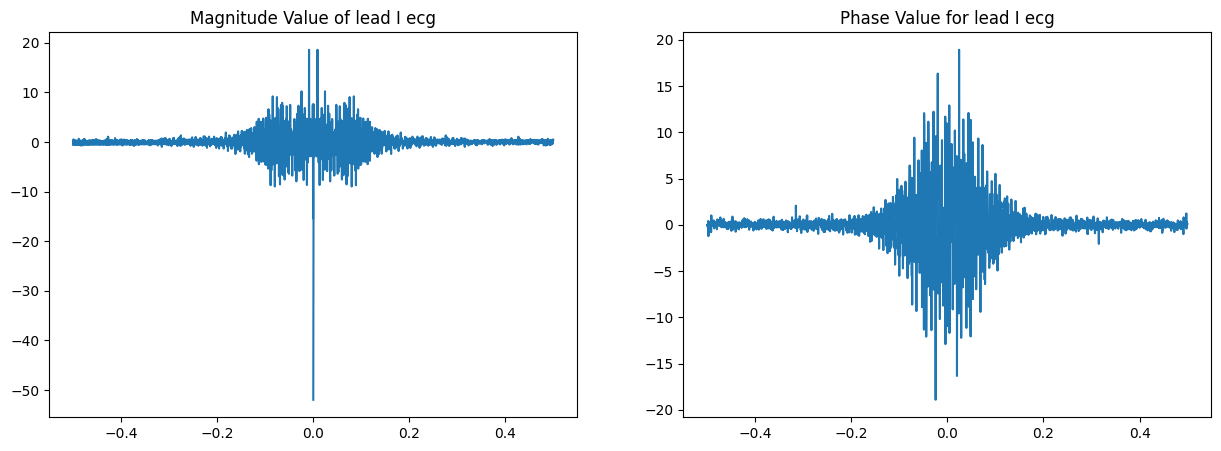

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(freq, freq_data.real)
plt.title('Magnitude Value of lead I ecg')

plt.subplot(1,2,2)
plt.plot(freq, freq_data.imag)
plt.title('Phase Value for lead I ecg')

<h4> Multi-channel Batch ECG FFT </h4>

In [85]:
batch_freq = np.fft.fftfreq(x.shape[1], 1/250)
batch_freq_data = np.fft.fft(x)

In [97]:
np.abs(batch_freq_data[0])

array([[0.17 , 0.15 ],
       [0.16 , 0.16 ],
       [0.155, 0.125],
       ...,
       [0.39 , 0.34 ],
       [0.395, 0.375],
       [0.395, 0.375]], shape=(2500, 2))